In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
import planarity
from networkx.algorithms import community
import make_mst
import make_pmfg

In [6]:
raw_data = pd.read_csv('cleaned_data.csv',index_col=0)
one_month = raw_data[raw_data['month']=='2010-11']

# of nodes, 63
# of edges, 1953


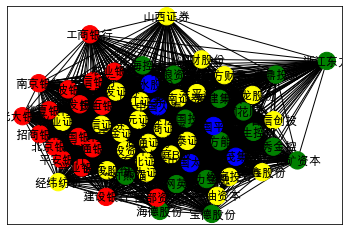

In [9]:
## corr 算法

G = make_mst.get_graph_corr('2010-11')
color = []
color_map = dict(G.nodes)
# print(color_map)
for node in color_map.items():
    # print(node)
    color.append(node[1]['color'])
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

nx.draw_networkx(G,node_color=color)
# G.edges(data=True)
# sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse = True)
print('# of nodes,', nx.number_of_nodes(G))
print('# of edges,', nx.number_of_edges(G))


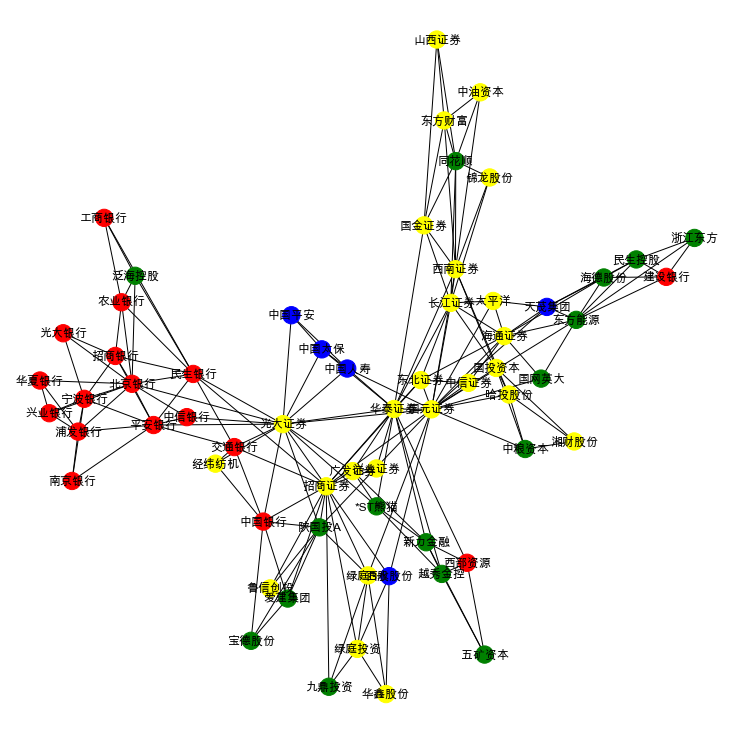

In [10]:
pfmg = make_pmfg.compute_PMFG(G)
node_list = list(pfmg.nodes())

for i in range(len(node_list)):
    # print(node_list[i])
    if one_month[one_month['简称']==node_list[i]].iloc[0]['subsector'] == '资本市场服务':
        pfmg.nodes[node_list[i]]['color'] ='yellow'
    elif one_month[one_month['简称']==node_list[i]].iloc[0]['subsector'] == '保险业':
        pfmg.nodes[node_list[i]]['color'] ='blue'
    elif one_month[one_month['简称']==node_list[i]].iloc[0]['subsector'] == '货币金融':
        pfmg.nodes[node_list[i]]['color'] ='red'
    elif one_month[one_month['简称']==node_list[i]].iloc[0]['subsector'] == '其他金融业':
        pfmg.nodes[node_list[i]]['color'] ='green'
color = []
color_map = dict(pfmg.nodes)
# print(color_map)
for node in color_map.items():
    color.append(node[1]['color'])
plt.figure(figsize=(10,10))
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
nx.draw_spring(pfmg,with_labels=True,node_color = color)